In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Data augmentation is a key technique used in computer vision. It helps neural networks to learn useful representations and generalize better to unseen samples. In this tutorial we show how to do data augmentation in Pytorch EO. We provide default integration with `albumentations`.

In [63]:
from pytorch_eo.datasets.eurosat import EuroSATRGB

ds = EuroSATRGB() # no transform
ds.setup()

If no transforms are provided to the dataset, images will always be loaded in the same way.

In [64]:
import matplotlib.pyplot as plt

def plot_sample(ds, classes, ix, image_field='image'):
    fig = plt.figure(figsize=(10, 10))
    for i in range(5):
        sample = ds[ix]
        img, label = sample[image_field], sample['label']
        ax = plt.subplot(1, 5, i + 1)
        ax.imshow(img)
        ax.set_title(classes[label])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

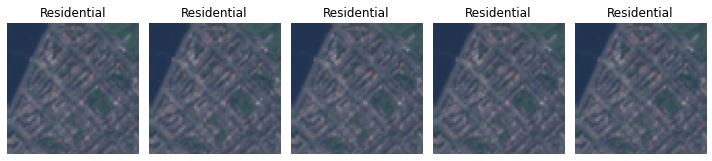

In [65]:
plot_sample(ds.train_ds, ds.classes, 0)

By providing transforms, we can have more variety in our data.

In [66]:
import albumentations as A

trans = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5)
])

ds = EuroSATRGB(train_trans=trans)
ds.setup()

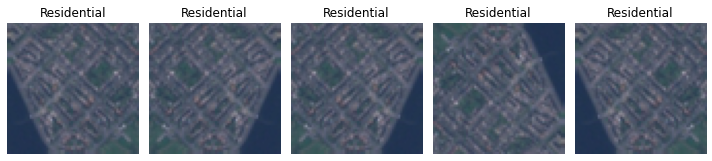

In [67]:
plot_sample(ds.train_ds, ds.classes, 0)

You can define different transforms for train-test-val splits

In [68]:
train_trans = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5)
])

test_trans = A.Compose([
    A.RandomResizedCrop(64,64)
])


ds = EuroSATRGB(train_trans=train_trans, test_trans=test_trans)
ds.setup()

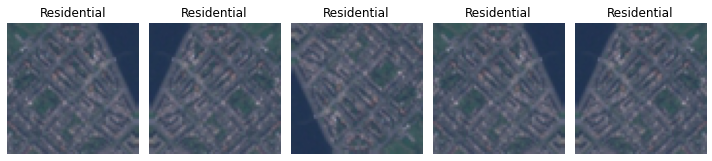

In [69]:
plot_sample(ds.train_ds, ds.classes, 0)

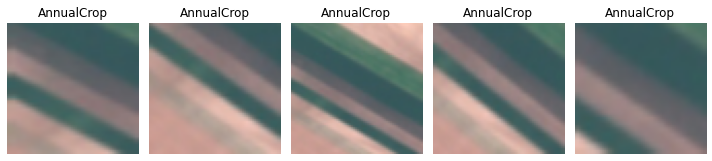

In [70]:
plot_sample(ds.test_ds, ds.classes, 0)

If you use different names for your inputs-outputs, you should define them in the transforms so the same augmentations are applied to all the samples. You will have to use this for data fusion or multi task applications.

In [71]:
from pytorch_eo.utils.datasets.RGBImageDataset import RGBImageDataset
from pytorch_eo.utils.datasets.ConcatDataset import ConcatDataset

images_ds = RGBImageDataset(ds.df.image.values)
labels_ds = ds.df.label.values

trans = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5)
], additional_targets={'abc': 'image'}) # use 'abc' as the 'image' field

dsc = ConcatDataset({'abc': images_ds, 'label': labels_ds}, trans, image_field='abc') 

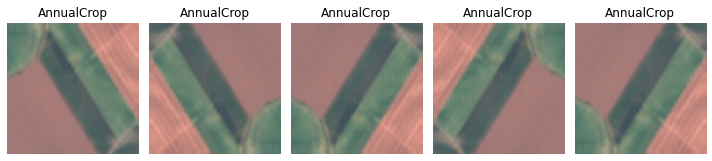

In [72]:
plot_sample(dsc, ds.classes, 0, image_field='abc')

## Other tasks

Torchvision support for augmenting bounding boxes, segmentation masks, keypoints, ... is limited. For that, `albumentations` is a great alternative.

In [73]:
# TODO: examples